In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
from torchvision import models
import os,sys
import matplotlib.pyplot as plt
import numpy as np
from utils import train,test
import pandas as pd
import glob
from skimage import io

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
def load_torch_model(model_ft,model_path,device):
    for param in model_ft.parameters():
        param.requires_grad = False    
    param_update=[]
    for name,param in model_ft.layer3.named_parameters():
        param.requires_grad = True
        param_update.append(param)
    for name,param in model_ft.layer4.named_parameters():
        param.requires_grad = True
        param_update.append(param)
    for name,param in model_ft.fc.named_parameters():
        param.requires_grad = True
        param_update.append(param)
    model_ft = nn.DataParallel(model_ft)
    
    model_wts = torch.load(model_path)
    model_ft.load_state_dict(model_wts)    
    model_ft = model_ft.to(device)
    return model_ft

In [3]:
def  batch_mil_sampling(imagelist,region_result_npy,mil_data_save_dir,class_name,class_dict,model_ft):
    images = io.imread_collection(imagelist)    
    images = np.stack(images)
#    images_torch = Variable(torch.from_numpy(images.copy().transpose((0,3, 1, 2))).float().div(255).cuda())
    model_ft.eval() 
    with torch.no_grad():
        test_epoch = test.Test_epoch_from_array(model_ft,images,256)
        output_predict = test_epoch.predict()
    output_order = np.argsort(output_predict[:,class_dict[class_name]])[::-1]
    if class_dict[class_name] ==0:
        #weight = 0.5
        output_slect = output_order[:int(0.5 * len(output_order))]
    else:
        #weight = 0.2
        output_slect = output_order[int(0.3 * len(output_order)):int(0.5 * len(output_order))]
    for i in range(len(output_slect)):
        os.system('cp ' + imagelist[output_slect[i]] + ' ' + os.path.join(mil_data_save_dir,class_name))
        file_name = os.path.basename(imagelist[output_slect[i]]).split('.')[0]
        # e.g. TCGA-5M-AAT6-01Z-00-DX1-98_6_3_0_M_norm.png to TCGA-5M-AAT6-01Z-00-DX1-98_6_3_0_M_norm
        x = int(file_name.split('-')[-1].split('_')[0])
        # e.g. TCGA-5M-AAT6-01Z-00-DX1-98_6_3_0_M_norm to 98
        y = int(file_name.split('-')[-1].split('_')[1])
        # e.g. TCGA-5M-AAT6-01Z-00-DX1-98_6_3_0_M_norm to 6       
        y_nd = int(file_name.split('-')[-1].split('_')[2])
        # e.g. TCGA-5M-AAT6-01Z-00-DX1-98_6_3_0_M_norm to 3
        y_nd_i = int(file_name.split('-')[-1].split('_')[3])
        region_result_npy[y * y_nd + y_nd_i,x] = int(class_dict[class_name]) + 1

    return region_result_npy  

In [4]:
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")        
    batch_size = 256
    data_dir_ori = {'train':'/cptjack/totem_disk/totem/M_MSI_MSS/normal/train',
                'val':'/cptjack/totem_disk/totem/M_MSI_MSS/normal/val'}
    
    model_save_path = '/cptjack/totem_disk/totem/kwong/CRC_DC_TRAIN/MIL'
    model_base_name = 'resnet_18'

    model_ft = models.resnet18(pretrained = False)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)
    for param in model_ft.parameters():
        param.requires_grad = False    
    param_update=[]
    for name,param in model_ft.layer3.named_parameters():
        param.requires_grad = True
        param_update.append(param)
    for name,param in model_ft.layer4.named_parameters():
        param.requires_grad = True
        param_update.append(param)
    for name,param in model_ft.fc.named_parameters():
        param.requires_grad = True
        param_update.append(param)
#    model_ft = nn.DataParallel(model_ft)
    model_ft = model_ft.to(device)
    
    result_sub = pd.read_csv('/cptjack/totem_disk/totem/kwong/CRC_DC_TRAIN/MIL/TCGA_analysis_statistic_result_0810.csv')
    result_name = sorted(list(result_sub[result_sub['percentage_msi'] + result_sub['percentage_mss']>0].case))
    
    
    classes = sorted(os.listdir(data_dir_ori['train']))
    class_dict = {x:i for i,x in enumerate(sorted(classes))}
    
    region_prediction_dir = '/cptjack/totem_data_backup/totem/COLORECTAL_DATA/M_TCGA_analysis_region_prediction_npy_norm_3/'
    
    mil_sample_result_dir = '/cptjack/totem_disk/totem/sample_result_MIL'
    if not os.path.exists(mil_sample_result_dir):
        os.makedirs(mil_sample_result_dir)
    
    mil_data_save_dir = '/cptjack/totem_disk/totem/MSI_MSS_MIP'

    all_train_loss = []
    all_val_loss = []
    
    all_train_acc = []
    all_val_acc = []
    

In [5]:
    for m in range(6):
        # m is the round of MIL processing 
        if os.path.exists(mil_data_save_dir):
            os.system('rm -r ' + mil_data_save_dir)
        print('-' * 16)
        print('Round ' + str(m) + ' is processing: ')
        #model_path = '/cptjack/totem_disk/totem/kwong/CRC_DC_TRAIN/MIL/resnet_18_'+ str(m-1) + '.pth'
        #model_ft = load_torch_model(model_path,device)

        for class_name in classes: 
            if not os.path.exists(os.path.join(mil_data_save_dir,class_name)):
                os.makedirs(os.path.join(mil_data_save_dir,class_name))
            for image_name in result_name:
                imagelist = glob.glob(os.path.join(data_dir_ori['train'],class_name,'*' + image_name.split('.')[0] + '*'))
                if len(imagelist) > 0:
                    preview_filename = image_name + '-region_3_class_output.npy'
                    if os.path.exists(region_prediction_dir + preview_filename):
                        region_result_npy = np.load(region_prediction_dir + preview_filename)
                        region_result_npy[region_result_npy !=3] =0
                        try:
                            region_result_npy = batch_mil_sampling(imagelist,region_result_npy,mil_data_save_dir,class_name,class_dict,model_ft)
                            np.save(os.path.join(mil_sample_result_dir,image_name.split('.')[0] + '_' + str(m) + '_sresult.npy') ,region_result_npy)
                        except Exception:
                            print('Round ' + str(m) + '_' + image_name + ' error!')
        
        print('Round ' + str(m) + ' begin training: ')

        data_dir = {'train':mil_data_save_dir,
                'val':'/cptjack/totem_disk/totem/M_MSI_MSS/normal/val'}
        
        train_epoch = train.Epoch(
                model_ft, 
                data_dir,
                m, 
                model_save_path,
                model_base_name,
                batch_size
                )
#        try:        
        model_ft,train_loss,train_acc,val_loss,val_acc = train_epoch.mip_run()                            
        all_train_acc.append(train_acc)
        all_train_loss.append(train_loss)
        all_val_acc.append(val_acc)
        all_val_loss.append(val_loss)      
#        except Exception:
#            print('Round ' + str(m) + ' training error!')
    np.save('all_train_acc.npy', all_train_acc)
    np.save('all_train_loss.npy', all_train_loss)
    np.save('all_val_acc.npy', all_val_acc)
    np.save('all_val_loss.npy', all_val_loss)
    
    


----------------
Round 0 is processing: 


/cptjack/totem_disk/totem/kwong/CRC_DC_TRAIN/MIP/utils/test.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_predict_batch = F.softmax(output)
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in not_equal
/cptjack/totem_disk/totem/kwong/CRC_DC_TRAIN/MIP/utils/test.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_predict = F.softmax(output)


Round 0 begin training: 
----------
train: 100%|██████████| 302/302 [21:44<00:00,  4.81s/it, CrossEntropyLoss - 0.6346, Balanced_acc - 0.6913, recall - 0.6995]
train Loss: 0.6605 Acc: 0.5910
val: 100%|██████████| 329/329 [37:41<00:00,  5.56s/it, CrossEntropyLoss - 0.7295, Balanced_acc - 0.4485, recall - 0.5]   
val Loss: 0.7481 Acc: 0.4758
----------------
Round 1 is processing: 
Round 1 begin training: 
----------
train: 100%|██████████| 302/302 [24:08<00:00,  4.20s/it, CrossEntropyLoss - 0.4552, Balanced_acc - 0.7762, recall - 0.7778]
train Loss: 0.5041 Acc: 0.7730
val: 100%|██████████| 329/329 [23:52<00:00,  3.25s/it, CrossEntropyLoss - 1.117, Balanced_acc - 0.4106, recall - 0.4464] 
val Loss: 1.0388 Acc: 0.5043
----------------
Round 2 is processing: 
Round 2 begin training: 
----------
train: 100%|██████████| 302/302 [21:49<00:00,  4.00s/it, CrossEntropyLoss - 0.4543, Balanced_acc - 0.7756, recall - 0.7814]
train Loss: 0.4021 Acc: 0.8176
val: 100%|██████████| 329/329 [22:07<00:00,

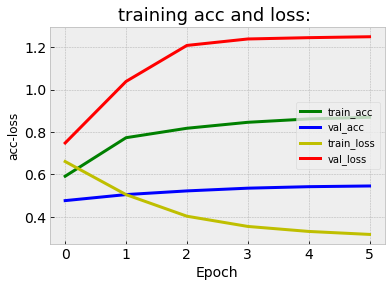

In [6]:
    plt.figure()
    plt.style.use('bmh') # bmh
    plt.title("training acc and loss: ", fontsize=18)
    train_acc, = plt.plot(all_train_acc,c = 'g',linewidth=3)
    val_acc, = plt.plot(all_val_acc,c = 'b',linewidth=3)
    train_loss, = plt.plot(all_train_loss,c = 'y',linewidth=3)
    val_loss, = plt.plot(all_val_loss,c = 'r',linewidth=3)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel('acc-loss')
    plt.tick_params(axis='both', labelsize=14)
    plt.legend(handles=[train_acc, val_acc,train_loss,val_loss], labels=['train_acc', 'val_acc','train_loss','val_loss'],
        loc='center right') 
    plt.show()
    plt.close()

In [7]:
train_loss